# Imports and setup

In [34]:
from transformers import ElectraForPreTraining, ElectraTokenizerFast, pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from datasets import Dataset
from datasets import load_dataset, ClassLabel
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
import nlp
import matplotlib.pyplot as plt

- Small-E-Czech is a transformer trained on Czech corpora by Seznam

In [2]:
model_name = "Seznam/small-e-czech"
# pipe = pipeline(task="text-classification", model=model_name)

In [3]:
print(torch.version.cuda)
print(torch.cuda.is_available())

11.6
True


# Data loading, manipulation and exploration

In [4]:
# df = pd.read_csv('data/sample_data.csv')
# df_train, df_test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

# df_train.to_csv('data/sample_data_train.csv', index=False)
# df_test.to_csv('data/sample_data_test.csv', index=False)

# X_train = pd.read_pickle('data/X_known.pkl')
# y_train = pd.read_pickle('data/y_known.pkl')

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=17)

# df_train = pd.concat([X_train, y_train], axis=1)
# df_train.columns = ['text', 'label']
# df_test = pd.concat([X_test, y_test], axis=1)
# df_test.columns = ['text', 'label']

# df_train.to_csv('data/twitter_train.csv', index=False)
# df_test.to_csv('data/twitter_test.csv', index=False)

X_train = pd.read_csv('data/twitter_train.csv')
y_train = pd.read_csv('data/twitter_test.csv')

X_train.head()

,text,label
0,Za vlády @AndrejBabis se vše šíleně zdražilo. ...,before
1,@TheLilek @Don_Vito007 @michalsnobr @SpoluKoal...,after
2,@Telicka @AndrejBabis Nic.\nVšiml si ho tam ně...,after
3,@RomanKosek1 @AndrejBabiis @AndrejBabis Fake ú...,after
4,Tak jsem se konečně dostal k #ČauLidi a co nes...,after


In [5]:
# load into hugging_face dataset object and cast label as target

ds = load_dataset('csv', data_files={'train': 'data/twitter_train.csv', 'test': 'data/twitter_test.csv'})
label_features = ClassLabel(names=["before", "after"])

ds['train'] = ds['train'].cast_column("label", label_features)
ds['test'] = ds['test'].cast_column("label", label_features)

Using custom data configuration default-bbf2f84eeccc0b67
Found cached dataset csv (C:/Users/capek/.cache/huggingface/datasets/csv/default-bbf2f84eeccc0b67/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-4345259839aa99c0.arrow
Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-c1fc664ea891a51e.arrow


In [6]:
# examine values

print(ds['train'].features)
print(ds['train'][0])
print(ds['test'].features)
print(ds['test'][0])

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['before', 'after'], id=None)}
{'text': 'Za vlády @AndrejBabis se vše šíleně zdražilo. Hlavně letos. Ve výsledku mají důchodci nižší kupní sílu než za pravicových vlád. Ale samozřejmě za to může inflace přivezená ze zahraničí. Ne nemůže. Můžete za to vy a vaše vláda!!!', 'label': 0}
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['before', 'after'], id=None)}
{'text': 'A jedeeeeeem! Tohle si nechte zaramovat a povesit na zed v cele, @AndrejBabis ', 'label': 0}


In [7]:
# features = ds.features.copy()
# features["label"] = ClassLabel(names=["není zvíře", "je zvíře"])
# def adjust_labels(batch):
# #     batch["label"] = [sentiment + 1 for sentiment in batch["label"]]
#     return batch
# ds = ds.map(adjust_labels, batched=True, features=features)
# ds
# ds.features

In [8]:
# display dataset as pandas dataframe

ds['train'].set_format(type="pandas")
df = ds['train'][:]
df.head()

,text,label
0,Za vlády @AndrejBabis se vše šíleně zdražilo. ...,0
1,@TheLilek @Don_Vito007 @michalsnobr @SpoluKoal...,1
2,@Telicka @AndrejBabis Nic.\nVšiml si ho tam ně...,1
3,@RomanKosek1 @AndrejBabiis @AndrejBabis Fake ú...,1
4,Tak jsem se konečně dostal k #ČauLidi a co nes...,1


In [9]:
# map labels to label name

def label_int2str(row):
    return ds["train"].features["label"].int2str(row)

df['label_name'] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,Za vlády @AndrejBabis se vše šíleně zdražilo. ...,0,before
1,@TheLilek @Don_Vito007 @michalsnobr @SpoluKoal...,1,after
2,@Telicka @AndrejBabis Nic.\nVšiml si ho tam ně...,1,after
3,@RomanKosek1 @AndrejBabiis @AndrejBabis Fake ú...,1,after
4,Tak jsem se konečně dostal k #ČauLidi a co nes...,1,after


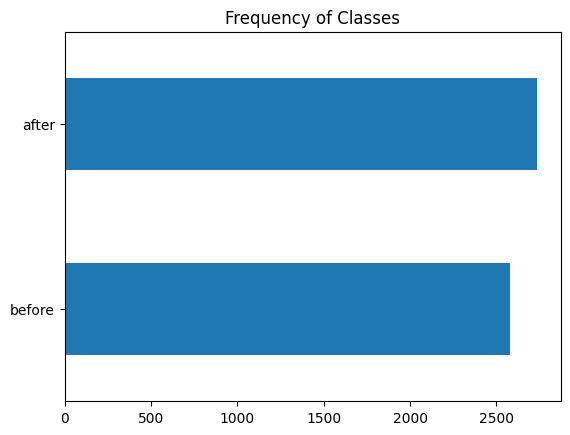

In [10]:
# displaying class frequencies

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

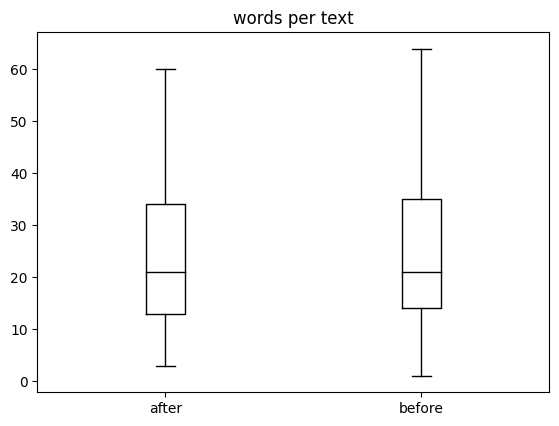

In [11]:
# displaying boxplots for word frequencies per class

df["words per text"] = df["text"].str.split().apply(len)
df.boxplot("words per text", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [12]:
ds.reset_format()

In [18]:
list(df['text'])

['Za vlády @AndrejBabis se vše šíleně zdražilo. Hlavně letos. Ve výsledku mají důchodci nižší kupní sílu než za pravicových vlád. Ale samozřejmě za to může inflace přivezená ze zahraničí. Ne nemůže. Můžete za to vy a vaše vláda!!!',
 '@TheLilek @Don_Vito007 @michalsnobr @SpoluKoalice Taky bych dopnila, ze Fico vladl 12 let, takze spis Babis je proti nemu cuckar. A Slovaci si zvolili Kisku, cloveka v ty dobe s nulovymi politickymi zkusenostmi. A jeste pred vrazdou Kuciaka, co vedlo k padu Smeru. Jde to, kdyz se chce.',
 '@Telicka @AndrejBabis Nic.\nVšiml si ho tam někdo?',
 '@RomanKosek1 @AndrejBabiis @AndrejBabis Fake účet nemám pane mohu sem dát klidně i víc fotek. Asi tak chytrý nejste',
 'Tak jsem se konečně dostal k #ČauLidi a co neslyším. @AndrejBabis je tady pro všechny, jejichž zástupci se nedostali do sněmovny - pro voliče komoušů i nácků, pro extremisty zleva  i prava.\n\nSnadněji doznat, že vlastně nemá žádný směr a ideál a jen baží po moci snad ani nejde.',
 '@alenaschillero

In [50]:
class TransformerClass:
    
    def __init__(self, model_name="Seznam/small-e-czech", labels_count=2):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=labels_count).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
    def tokenize_series(self, texts: pd.Series, padding=True, truncation=True):
        dataset = Dataset.from_pandas(pd.DataFrame(texts))
        text_idx = list(dataset.features.keys())[0]
        print(dataset.map(self.tokenizer(list(texts), padding=padding, truncation=truncation), batched=True))
        return None

    
    def extract_hidden_states(self, texts: pd.Series):
        tokenized = self.tokenize_batch(texts)
        # Place model inputs on the GPU
        inputs = {k:v.to(device) for k,v in tokenized.items() 
                  if k in self.tokenizer.model_input_names}
        # Extract last hidden states
        with torch.no_grad():
            last_hidden_state = model(**inputs).last_hidden_state
        # Return vector for [CLS] token
        return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
    
        
s = TransformerClass()
s.tokenize_series(df['text'])

Some weights of the model checkpoint at Seznam/small-e-czech were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at Seznam/small-e-czech and are newly initialized: ['classifier.dense.weight', 'classifier.

  0%|          | 0/6 [00:00<?, ?ba/s]

TypeError: 'BatchEncoding' object is not callable

# Tokenization

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_data_train = tokenizer(ds['train']['text'], return_tensors="tf", padding=True, truncation=True)
labels_train = np.array(ds['train']['label'])
tokenized_data_test = tokenizer(ds['test']['text'], return_tensors="tf", padding=True, truncation=True)
labels_test = np.array(ds['test']['label'])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [14]:
# attention mask umožňuje ignorovat padding
tokenized_data_train

{'input_ids': <tf.Tensor: shape=(5314, 124), dtype=int32, numpy=
array([[    2,   272,  5052, ...,     0,     0,     0],
       [    2,    36,  2299, ...,     0,     0,     0],
       [    2,    36,  6152, ...,     0,     0,     0],
       ...,
       [    2, 21712,  3073, ...,     0,     0,     0],
       [    2,    36, 21780, ...,     0,     0,     0],
       [    2,    36, 29690, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(5314, 124), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(5314, 124), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [15]:
# navrácení tokenů k id
tokens = tokenizer.convert_ids_to_tokens(tokenized_data_train[0].ids)
tokens

['[CLS]',
 'za',
 'vlády',
 '@',
 'andrej',
 '##ba',
 '##bis',
 'se',
 'vše',
 'šílen',
 '##ě',
 'zdra',
 '##žilo',
 '.',
 'hlavně',
 'letos',
 '.',
 've',
 'výsledku',
 'mají',
 'důchodci',
 'nižší',
 'kupní',
 'sílu',
 'než',
 'za',
 'pravi',
 '##cových',
 'vlád',
 '.',
 'ale',
 'samozřejmě',
 'za',
 'to',
 'může',
 'inflace',
 'přivez',
 '##ená',
 'ze',
 'zahraničí',
 '.',
 'ne',
 'nemůže',
 '.',
 'můžete',
 'za',
 'to',
 'vy',
 'a',
 'vaše',
 'vláda',
 '!',
 '!',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '

In [16]:
# tisk jako string
tokenizer.convert_tokens_to_string(tokens)

'[CLS] za vlády @ andrejbabis se vše šíleně zdražilo. hlavně letos. ve výsledku mají důchodci nižší kupní sílu než za pravicových vlád. ale samozřejmě za to může inflace přivezená ze zahraničí. ne nemůže. můžete za to vy a vaše vláda!!! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [17]:
# počet tokenů ve slovníku
tokenizer.vocab_size

30522

In [18]:
# maximální délka vektoru
# (... mám o tom nějaké pochybnosti ....)

tokenizer.model_max_length

1000000000000000019884624838656

In [19]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [20]:
# tokenizace celého datasetu
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenized = ds.map(tokenize, batched=True, batch_size=None)
tokenized

Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8fd833be02e97cd7.arrow
Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8e6648eacea06ce7.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5314
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 591
    })
})

# Feature extraction

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at Seznam/small-e-czech were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
# tensorflow is also available
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_name)

Some layers from the model checkpoint at Seznam/small-e-czech were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at Seznam/small-e-czech.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [23]:
text = "Toto je zkušební text"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

print(outputs.last_hidden_state.size())

Input tensor shape: torch.Size([1, 6])
BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[ 3.6099e-01,  5.5451e-05, -1.2910e-04,  ...,  2.7866e-04,
           4.9307e-01, -1.3343e-04],
         [-1.9554e-01, -3.0069e-04, -1.0528e-04,  ...,  9.9554e-05,
          -1.1577e+00, -1.9735e-04],
         [-4.4456e-01, -4.6349e-04, -9.3823e-05,  ...,  3.3249e-04,
           1.7378e-01, -1.3628e-04],
         [-2.3099e-02, -2.4707e-04, -7.6978e-05,  ...,  6.1547e-04,
           6.3977e-01, -1.4361e-04],
         [ 1.0250e+00, -2.7454e-04, -7.3392e-05,  ...,  7.0218e-04,
           4.0734e-01, -2.5776e-04],
         [ 3.6190e-01,  5.5544e-05, -1.2914e-04,  ...,  2.7876e-04,
           4.9256e-01, -1.3352e-04]]], device='cuda:0'), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)
torch.Size([1, 6, 256])


<i>"Looking at the hidden state tensor, we see that it has the shape [batch_size, n_tokens, hidden_dim]. In other words, a 256-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:"</i>

In [24]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 256])

In [25]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [26]:
tokenized.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
# token_type_ids?

In [27]:
# hidden states
hidden = tokenized.map(extract_hidden_states, batched=True)
hidden

Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-4a0eac3c8afbb0d9.arrow
Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-87054d891f5378a1.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 5314
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 591
    })
})

In [28]:
X_train = np.array(hidden["train"]["hidden_state"])
X_test = np.array(hidden["test"]["hidden_state"])
y_train = np.array(hidden["train"]["label"])
y_test = np.array(hidden["test"]["label"])
X_train.shape, X_test.shape

((5314, 256), (591, 256))

# Feature visualization

In [29]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,12.555482,3.470858,0
1,13.835873,5.090692,1
2,5.522027,4.972481,1
3,8.073125,4.118404,1
4,12.141874,5.515906,1


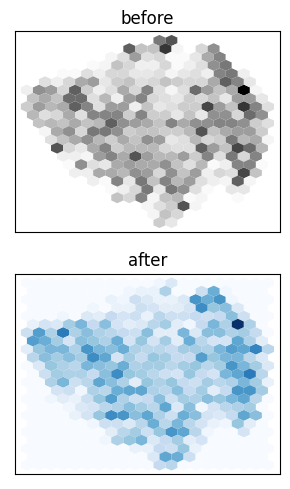

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(3,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues"]
labels = ds["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Modelling

In [31]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.5143824027072758

In [32]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.467005076142132

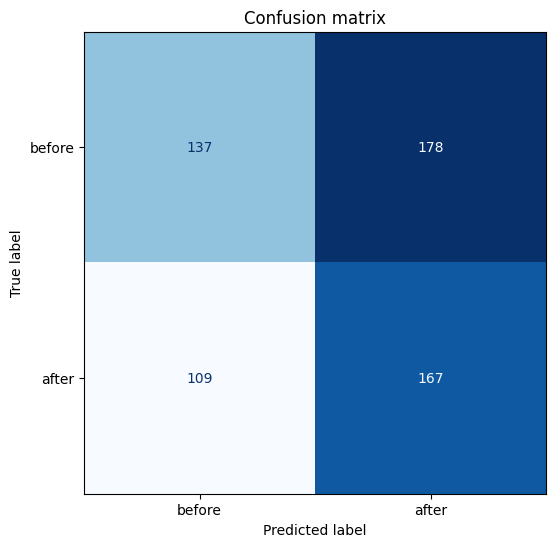

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_test)
plot_confusion_matrix(y_preds, y_test, labels)

In [34]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at Seznam/small-e-czech were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at Seznam/small-e-czech and are newly initialized: ['classifier.dense.bias', 'classifier.de

In [35]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [36]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, IntervalStrategy

batch_size = 256
logging_steps = len(ds["train"]) // batch_size
my_model_name = f"{model_name}-finetuned-sample"
training_args = TrainingArguments(output_dir=my_model_name,
                                  num_train_epochs=20,
                                  learning_rate=4e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.1,
                                  evaluation_strategy=IntervalStrategy.STEPS,
                                  eval_steps = 25,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error",
                                  metric_for_best_model = 'val_loss',
                                  load_best_model_at_end=True)

In [37]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized["train"],
                  eval_dataset=tokenized["test"],
                  tokenizer=tokenizer)
trainer.train();

C:\Users\capek\pycharm_projects\Transformers_for_czech_language\venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1
25,0.692600,0.694460,0.483926,0.363210
50,0.690200,0.691887,0.500846,0.423701
75,0.682900,0.669870,0.602369,0.602651
100,0.635700,0.635275,0.666667,0.658192
125,0.596500,0.629205,0.649746,0.649887
150,0.546400,0.608014,0.680203,0.674453
175,0.517800,0.608081,0.692047,0.690699
200,0.443400,0.618577,0.688663,0.689002
225,0.416500,0.616061,0.698816,0.693830
250,0.400000,0.620705,0.705584,0.705514


In [38]:
preds_output = trainer.predict(tokenized["test"])
preds_output

PredictionOutput(predictions=array([[ 1.2226062 , -0.99947387],
       [-0.6340263 ,  0.56542814],
       [ 1.3644406 , -1.1134596 ],
       ...,
       [ 1.1246133 , -0.9219734 ],
       [ 0.04703501, -0.06394254],
       [ 0.00180215,  0.01157364]], dtype=float32), label_ids=array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0

In [39]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_preds

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,

In [40]:
# pd.DataFrame(y_preds, columns=['prediction']).to_csv('')

In [41]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_preds, y_test))

0.7038917089678511


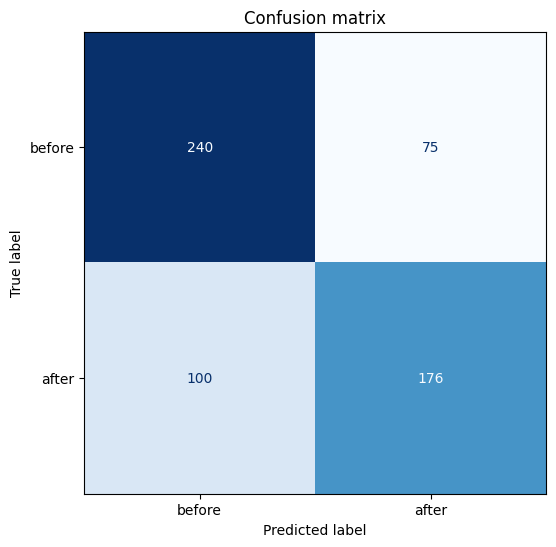

In [42]:
plot_confusion_matrix(y_preds, y_test, labels)

- keras finetuning

In [43]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels))

In [44]:
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = tokenized["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = tokenized["test"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

In [45]:
# does not work
# import tensorflow as tf

# tf_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=tf.metrics.SparseCategoricalAccuracy())

# tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

# Error analysis

<i>"Before moving on, we should investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label:"</i>

In [46]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}
     

In [47]:
# Convert our dataset back to PyTorch tensors
tokenized.set_format("torch", 
                            columns=["input_ids", "token_type_ids", "attention_mask", "label"])
# Compute loss values
tokenized["test"] = tokenized["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [48]:
tokenized.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tokenized["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [49]:
with pd.option_context("display.max_colwidth", None):
    display(df_test.sort_values("loss", ascending=False).head(10))

,text,label,predicted_label,loss
17,@Pes_Mamlas @vrchnikomisar @maestrosill @AndrejBabis Používají to i tady 😊,before,after,2.729251
518,"@pavelvond @CRoPlus @MUNI_FSS @Radiozurnal1 Babis musí zmizet, prymula vojta adam zbytek prasat prezident sněma Ovčačku tebe si nechám na posled 500 kylo má ta puma 1 tiden pak to udělá bum zmizte jedno kam do pekel hrad bude prazdni",before,after,2.698485
291,@petrskala90 @AndrejBabis Pro číslo 25085 by to měly být spíš stovky let v krimu.,before,after,2.678246
244,@MirekTopolanek Babiš se spíš boji že se zas na něco přijde a to bude možná větší světový skandál,before,after,2.609626
355,"@JuraB15 @alenaschillerov @AndrejBabis Hele mistře, většina lidí chodí nakupovat. Slepota nebo blbost postihla pouze malou část národa.",before,after,2.593253
395,"@KarelHavlicek_ @AndrejBabis Jaké jsou aktivity ""Rady pro strategické technologie"" ?\n",before,after,2.555347
164,"@AndrejBabis Nechápu, proč rozhodnutí nenecháte na novou sněmovnu.\nOpět předvolební pokrytecký populismus.",before,after,2.544648
233,@TomasZdechovsky @AndrejBabis @SpoluKoalice @STANcz @PiratskaStrana s tou koalicí bych to zas tak jednoduše neviděl. Z cyklu „Už se perou“\n\n,after,before,2.541491
110,@Oldrichsidl @Brendy1968 @AndrejBabis Proč tu připravenost neukázal a furt lhal? Nevíš?,before,after,2.539554
547,"@ehucka1 @rkaldy @KohoutPavel @PetrHonzejk Mně je jedno co Babiš říkal nebo neříkal. Já ho nevolil. Stejně jako jsem nevolil ani jednu z koalic. Proto si myslím, že můžu celkem objektivně říct, že všechny tyhle strany na sebe házeli špínu, tedy si nic nedluží a proto pláč není na místě.",after,before,2.534312


In [50]:
with pd.option_context("display.max_colwidth", None):
    display(df_test.sort_values("loss", ascending=True).head(10))

,text,label,predicted_label,loss
144,@JanaRichterov5 @AndrejBabis @Frekvence1 To tady bylo vždycky protože vlády od 89 pokazili co se dalo a házet všechno na Babiše není fér.,after,after,0.065552
139,"@JozefBrofsky @AndrejBabis Smííích,díky pobavilo!",after,after,0.066010
427,"@AndrejBabis @Frekvence1 Doufám,že jako za vaší vlády to už nikdy nebude😡",after,after,0.066150
66,@1pohled @Karel_IV62 @maestrosill @AndrejBabis Na Prahu ještě taky netáhli... tak asi zatím není obsazeno dost chalup.,after,after,0.066322
199,"@honigerova @BathoryBetka @MisaPopelky Ale vždyť to je jedno.\n\nKdyž Zeman skončí dříve, dříve začne prezidentovat Babiš.\n\nNic ho v politice už nedrží, ani to premiérování.",after,after,0.066520
540,"@chuckyja83 @tomaspek @oprokop @AndrejBabis Obávám se, že existují i jiné normality.",after,after,0.066538
261,@MMartyxx @MelkusovaIvana @SpacilMara @AdamekMiroslav @AndrejBabis Vůbec nic a to jí vydrží celé následující 4roky🙃,after,after,0.066615
439,"@AndrejBabis @Frekvence1 to je krutopřísný, říct to u Luboše Procházky, to zahřmělo, ne?",after,after,0.067089
256,"@katerinaflasko1 @beneslenka @alenaschillerov @KarelHavlicek_ @AndrejBabis @vondraczech @tomio_cz Jo přesně. Divnej pocit, jako …",after,after,0.067288
542,@zdenep @CT24zive @PokornyJan A Pokornému řekl (Babiš) …,after,after,0.067408


# Save model

In [51]:
path = f"models/{my_model_name}"
trainer.save_model(path)

In [52]:
classifier = pipeline("text-classification", model=path)

In [53]:
custom_tweet = "Dnes jsem si v parku hrál se psem."
preds = classifier(custom_tweet, return_all_scores=True)
preds

C:\Users\capek\pycharm_projects\Transformers_for_czech_language\venv\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.8871954083442688},
  {'label': 'LABEL_1', 'score': 0.11280456185340881}]]